In [1]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers import LSTM, GRU
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from utils.multi_gpu import make_parallel
from dataset.dataset import leer
from keras.utils.np_utils import to_categorical

### Cargar Datos
___

Por motivos de orden en el código las operaciones de :
-	load_CIFAR_one(filename)
-	load_CIFAR10

Y la creación del dataset de validación se agruparon en un solo código, que es instanciado en formato librería:


In [27]:
%%time
URL='data/'
Xtr,Ytr,Xt,Yt,Xv,Yv = leer(URL)
#Datos de entrenamiento
X_train = Xtr.reshape((Xtr.shape[0],32,32,3))
X_train = X_train.transpose([0, 3, 2, 1]) 
Y_train = to_categorical(Ytr, 10)
#Datos de Test
X_test  = Xt.reshape((Xt.shape[0],32,32,3))
X_test  = X_test.transpose([0, 3, 2, 1])
Y_test  = to_categorical(Yt, 10)
#Datos de Validación
X_val   = Xv.reshape((Xv.shape[0],32,32,3))
X_val   = X_val.transpose([0, 3, 2, 1])
Y_val   = to_categorical(Yv, 10)

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_val   = X_val.astype('float32')

CPU times: user 805 ms, sys: 701 ms, total: 1.51 s
Wall time: 1.43 s


In [28]:
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)
(50000, 10)
(10000, 10)


Se usará un dataset de entrenamiento de tamaño 4000, esto con el fin demás de asegurar el paralelismo al entrenar y evaluar la red.


In [29]:
print (X_val.shape)
print (Y_val.shape)

(4000, 3, 32, 32)
(4000, 10)


Se carga el mismo modelo usado en la parte (b), que podemos ver su esquema a continuación:


In [30]:
_size, n_channels, n_rows, n_cols = X_train.shape
n_classes = 10

In [31]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(n_channels, n_rows, n_cols)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 32, 32)        1792      
_________________________________________________________________
activation_28 (Activation)   (None, 64, 32, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 16, 16)        36928     
_________________________________________________________________
activation_29 (Activation)   (None, 64, 16, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 8, 8)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
__________

**(C)** Entrene la CNN definida en (b) utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es η = 10−4 o inferior, pero durante las primeras “epochs” el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje η = 10−3 y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a η = 10−5. Defina esta regla de ajuste para η y entrene la CNN definida en (a) durante 25 epochs. Construya un gráfico que muestre los errores de entrenamiento, validacíon y pruebas como función del número de “epochs”.

In [32]:
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

In [33]:
epochs = 25
batch_size=400

Con el paso que viene a continuación, logramos que todas las operaciones sobre el modelo pasen de ejecutarse en una GPU, a un esquema paralelo multi-GPU. Esto se verá reflejado en los tiempos de fit, registrados en los notebook.  

In [34]:
model = make_parallel(model, 8)

/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged.append(merge(outputs, mode='concat', concat_axis=0))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/Tarea/parte1/utils/multi_gpu.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  return Model(input=model.inputs, output=merged)


De acuerdo a lo indicado en clases se usará en todos los modelos, salvo en los que tengamos que comparar funciones de perdia, **categorical crossentropy**. Lo anterior porque a diferencia de por ejemplo binary crossentropy, en este problema **esperamos salidas mutuamente excluyentes por cada categoría.**

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

In [37]:
%%time
history = model.fit(X_train, Y_train,batch_size=batch_size,nb_epoch=epochs,verbose=0,
          validation_data=(X_test, Y_test),shuffle=True,callbacks=[lrate])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


CPU times: user 8min 27s, sys: 3min 14s, total: 11min 42s
Wall time: 2min 27s


### Comentarios
---

El uso de Learning Rate Schedules, según la literatura, indica que una **tasa de aprendiza variable ya sea de forma constante en el tiempo por tiempo (epochs) o aplicada puntualmente en determinados epochs** lograr un mayor rendimiento y un entrenamiento más rápido en algunos problemas. En este caso se usara la técnica de ir disminuyendo la tasa de aprendizaje gradualmente a los largo de los epochs con lo que se espera lograr el efecto de aprender rápidamente buenos pesos antes y ajustarlos más tarde.

Lo anterior podemos confirmarlo en el grafico que vemos acontinuación:

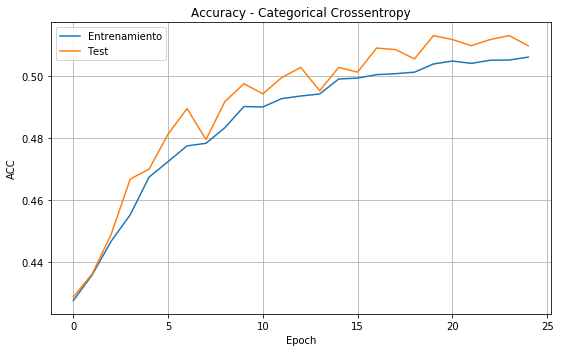

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Accuracy - Categorical Crossentropy')  
plt.ylabel('ACC')  
plt.xlabel('Epoch')  
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

Como podemos ver el proceso de entrenamiento de la red, es mucho mas suave pero que también crecer rápidamente como podemos ver en el grafico. Entiendo que esto puede deberse a que el uso Learning Rate Schedules tiene un efecto suavizador y acelerador del aprendizaje, que si bien logra solo 50% puede también deberse a que quizás es necesaria acompañarla de otros elementos como por ejemplo un dropout para regular este rápido aprendizaje.

In [49]:
scores = model.evaluate(X_val, Y_val)
print("")
print("Accuracy del modelo: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 4s     